In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv1D, Add, Dense, Flatten

In [3]:
# Load the dataset
file_path = 'C:/Users/dugga/OneDrive/Desktop/ML1/ML/data/AAPL.csv'
data = pd.read_csv(file_path)

In [5]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,12-12-1980,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1,15-12-1980,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
2,16-12-1980,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
3,17-12-1980,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
4,18-12-1980,0.118862,0.119420,0.118862,0.118862,0.092908,73449600


In [7]:
close_prices= data['Close'].values

In [9]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler.fit_transform(close_prices.reshape(-1, 1))

In [11]:
# Create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [13]:
# Define the sequence length
seq_length = 60

# Create sequences
X, y = create_sequences(close_prices_scaled, seq_length)
     
# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [15]:
# Define the ResNet-like model
input_layer = Input(shape=(seq_length, 1))

# First convolutional block
x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(input_layer)
x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
     
# Residual connection
x = Add()([x, input_layer])

In [17]:
# Second convolutional block
x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)

# Residual connection
x = Add()([x, input_layer])

# Flatten and output
x = Flatten()(x)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)

In [19]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
     
# Display the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 60, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 60, 64)            │             256 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, 60, 64)            │          12,352 │ conv1d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 60, 64)            │               0 │ conv1d_1[0][0],            │
│                               │                           │                 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_2 (Conv1D)             │ (None, 60, 64)            │          12,352 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_3 (Conv1D)             │ (None, 60, 64)            │          12,352 │ conv1d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 60, 64)            │               0 │ conv1d_3[0][0],            │
│                               │                           │                 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 3840)              │               0 │ add_1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 1)                 │           3,841 │ flatten[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 41,153 (160.75 KB)

 Trainable params: 41,153 (160.75 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 2.3247e-04 - val_loss: 1.6697e-05
Epoch 2/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.1266e-05 - val_loss: 0.0012
Epoch 3/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.2521e-05 - val_loss: 1.3244e-05
Epoch 4/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.7479e-05 - val_loss: 0.0011
Epoch 5/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2.6624e-06 - val_loss: 5.6360e-05
Epoch 6/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.4126e-06 - val_loss: 2.6564e-05
Epoch 7/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 8.0496e-06 - val_loss: 1.0452e-05
Epoch 8/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 8.3468e-06 - val_loss: 4.0657e-05
Epoch 9/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.5984e-04 - val_loss: 0.1180
Epoch 10/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.6429e-04 - val_loss: 5.8634e-05
Epoch 11/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 5.82

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0015   
Test Loss: 0.004444717429578304
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
RMSE: 12.131098053362678
MAE: 10.133552282107676
MAPE: 18.375470031575087


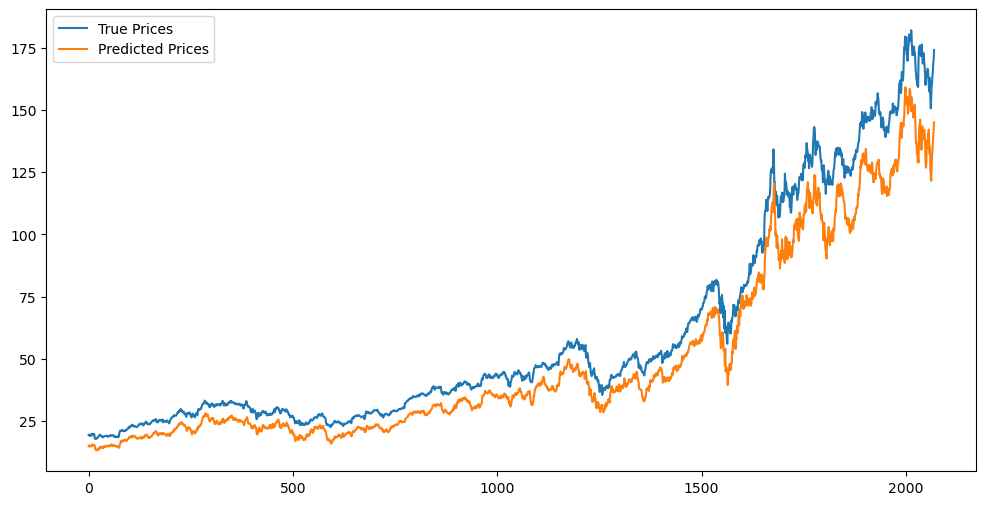

In [23]:
# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and true values to get the original scale
predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_inverse, predictions_inverse))
print(f'RMSE: {rmse}')

# Calculate MAE
mae = mean_absolute_error(y_test_inverse, predictions_inverse)
print(f'MAE: {mae}')

# Calculate MAPE
mape = np.mean(np.abs((y_test_inverse - predictions_inverse) / y_test_inverse)) * 100
print(f'MAPE: {mape}')

# Plot the predictions against the true values
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='True Prices')
plt.plot(predictions_inverse, label='Predicted Prices')
plt.legend()
plt.show()